In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from __future__ import print_function

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display a sample of the data
for i in range(28):
    for j in range(28):
        if x_train[2][i][j] == 0:
            print('.', end='')
        else:
            print('X', end='')
        
        if j == 27:
            print('', end='\n')

# Print correct label
print("Label: ", y_train[2])

# normalize our inputs to be in the range[-1, 1]
x_train = (x_train.astype(np.float32) - 127.5)/127.5

# convert x_train with a shape of (60000, 28, 28) to (60000, 784)
x_train = x_train.reshape(60000, 784)

............................
............................
............................
............................
............................
....................XXX.....
....XX..............XXX.....
....XX.............XXXX.....
....XX.............XXX......
....XX.............XXX......
...XXX.............XXX......
...XXX............XXXX......
...XXX............XXXX......
...XXX.........XXXXXX.......
...XXX...XXXXXXXXXXXX.......
...XXXXXXXXXXXXXXXXX........
....XXXXXXXX.....XXX........
.................XXX........
.................XXX........
.................XXX........
.................XXX........
.................XXX........
.................XXX........
.................XXX........
.................XXX........
............................
............................
............................
Label:  4


In [3]:
random_dim = 100

# Generator
generator = Sequential()

generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(Activation(lambda x: tf.nn.relu(x)-0.2*tf.nn.relu(-x)))

generator.add(Dense(512))
generator.add(Activation(lambda x: tf.nn.relu(x)-0.2*tf.nn.relu(-x)))

generator.add(Dense(1024))
generator.add(Activation(lambda x: tf.nn.relu(x)-0.2*tf.nn.relu(-x)))

generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Discriminator
discriminator = Sequential()

discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(Activation(lambda x: tf.nn.relu(x)-0.2*tf.nn.relu(-x)))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(512))
discriminator.add(Activation(lambda x: tf.nn.relu(x)-0.2*tf.nn.relu(-x)))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(256))
discriminator.add(Activation(lambda x: tf.nn.relu(x)-0.2*tf.nn.relu(-x)))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [4]:
# GAN

# initially -- since we only want to train either the generator or discriminator at a time
discriminator.trainable = False

# gan input (noise) will be 100-dimensional vectors
gan_input = Input(shape=(random_dim,))

gan = Model(inputs = gan_input, outputs = discriminator(generator(gan_input)) )

gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [5]:
epochs = 40
batch_size = 20000

# Number of batches
batch_count = x_train.shape[0] / batch_size

for i in range(epochs):
    
    print('-'*15, 'Epoch: ' + str(i), '-'*15)
    
    start = 0
    end = batch_size
    
    for j in range(batch_count):
        
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])        
        image_batch = x_train[start:end]
        
        # Generate fake MNIST images
        generated_images = generator.predict(noise)
        X = np.concatenate([image_batch, generated_images])
        # generated_images.shape = (batch_size, 784), X.shape = (2 * batch_size, 784)

        # Labels for generated and real data
        y_dis = np.zeros(2*batch_size)
        y_dis[:batch_size] = 1

        # Train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        # The y-label will be 1 since we want to train the generator such that the GAN gives out 1
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)
        
        # Update start and end
        start += batch_size
        end += batch_size

--------------- Epoch: 0 ---------------
--------------- Epoch: 1 ---------------
--------------- Epoch: 2 ---------------
--------------- Epoch: 3 ---------------
--------------- Epoch: 4 ---------------
--------------- Epoch: 5 ---------------
--------------- Epoch: 6 ---------------
--------------- Epoch: 7 ---------------
--------------- Epoch: 8 ---------------
--------------- Epoch: 9 ---------------
--------------- Epoch: 10 ---------------
--------------- Epoch: 11 ---------------
--------------- Epoch: 12 ---------------
--------------- Epoch: 13 ---------------
--------------- Epoch: 14 ---------------
--------------- Epoch: 15 ---------------
--------------- Epoch: 16 ---------------
--------------- Epoch: 17 ---------------
--------------- Epoch: 18 ---------------
--------------- Epoch: 19 ---------------
--------------- Epoch: 20 ---------------
--------------- Epoch: 21 ---------------
--------------- Epoch: 22 ---------------
--------------- Epoch: 23 ---------------
--

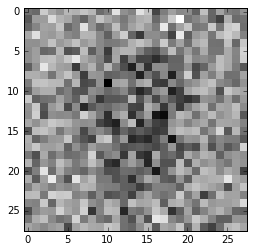

[ 0.42321676]


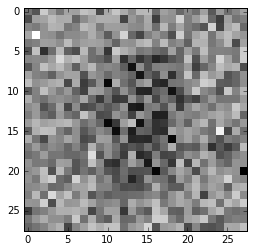

[ 0.38285968]


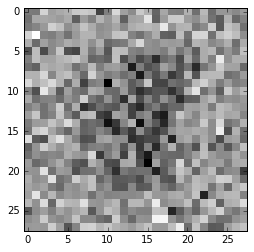

[ 0.39778459]


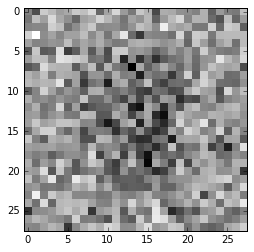

[ 0.37058303]


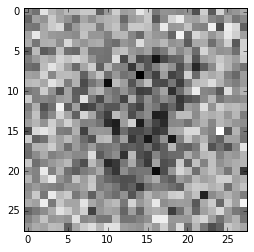

[ 0.3902508]


In [6]:
# Display a sample of the results
examples = 5
noise = np.random.normal(0, 1, size=[examples, random_dim])
generated_images = generator.predict(noise)
arr = discriminator.predict(generated_images)
generated_images = generated_images.reshape(examples, 28, 28)
for k in range(examples):
    plt.imshow(generated_images[k], interpolation='nearest', cmap='gray_r')
    plt.show()
    print(arr[k])

In [7]:
# Display a sample of the best results
while True:
    print(".", end="")
    noise = np.random.normal(0, 1, size=[1, random_dim])
    generated_images = generator.predict(noise)
    arr = discriminator.predict(generated_images)
    
    if arr[0] > 0.6:
        break

generated_images = generated_images.reshape(1, 28, 28)
plt.imshow(generated_images[0], interpolation='nearest', cmap='gray_r')
plt.show()
print(arr[0])

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 